# TransUNet Architecture: A Comprehensive Explanation
## TransUNet Atrchitecture
![TransUnet](https://miro.medium.com/v2/resize:fit:4800/format:webp/0*Xxb47-eg5JPa_b34.png)


## Overview

TransUNet (Transformers Make Strong Encoders for Medical Image Segmentation) is a hybrid deep learning architecture that combines the strengths of Convolutional Neural Networks (CNNs) and Vision Transformers (ViTs) for medical image segmentation tasks. Introduced by Chen et al. in 2021, it addresses the limitations of pure CNN-based architectures like U-Net by incorporating self-attention mechanisms to capture long-range dependencies.

## Motivation

Traditional U-Net architectures, while effective for medical image segmentation, have inherent limitations:

1. **Local receptive fields**: CNNs excel at capturing local patterns but struggle with global context
2. **Limited long-range dependencies**: Convolutional operations have difficulty modeling relationships between distant pixels
3. **Spatial information loss**: Deep CNNs progressively lose fine-grained spatial details

TransUNet was designed to overcome these limitations by leveraging Transformers' ability to model global context while preserving CNNs' strength in capturing low-level features.

## Architecture Components

### 1. CNN Encoder (Feature Extraction)

The architecture begins with a traditional CNN encoder, typically using ResNet-50 as the backbone:

**Purpose**: Extract hierarchical feature representations at multiple scales

**Process**:
- Input image passes through convolutional blocks
- Features are extracted at different resolutions (e.g., 1/2, 1/4, 1/8, 1/16 of original size)
- Lower-level features capture edges, textures, and local patterns
- Higher-level features capture semantic information

**Skip connections**: Feature maps from different encoder levels are preserved for later use in the decoder (similar to U-Net)

### 2. Transformer Encoder (Sequence Modeling)

This is the core innovation of TransUNet, where the architecture departs from traditional U-Net:

#### a) Patch Embedding

**Tokenization process**:
- The final CNN feature map (e.g., H/16 × W/16 × C) is divided into patches
- Each patch is treated as a token (similar to words in NLP)
- Patches are flattened and linearly projected to create patch embeddings
- Position embeddings are added to retain spatial information

**Example**: For a feature map of 14×14×512, we might create 196 patches (14×14), each represented as a 512-dimensional vector.

#### b) Multi-Head Self-Attention (MHSA)

**Purpose**: Capture global dependencies between all patches

**Mechanism**:
```
For each patch embedding:
1. Create Query (Q), Key (K), and Value (V) projections
2. Compute attention scores: Attention(Q,K,V) = softmax(QK^T / √d_k)V
3. Each patch "attends to" all other patches
4. Multiple attention heads learn different relationships
```

**Advantages**:
- Every patch can directly interact with every other patch (global receptive field)
- Captures long-range spatial dependencies
- Learns contextual relationships across the entire image

#### c) Transformer Layers

Multiple Transformer blocks are stacked, each containing:
- Multi-Head Self-Attention (MHSA)
- Layer Normalization
- Feed-Forward Network (MLP)
- Residual connections

**Information flow**:
```
Input → Layer Norm → MHSA → Residual Add →
Layer Norm → MLP → Residual Add → Output
```

### 3. Hybrid Decoder (Upsampling)

The decoder reconstructs the segmentation map using both CNN and Transformer features:

#### a) Cascaded Upsampler (CUP)

**Architecture**:
- Multiple upsampling stages (typically 4)
- Each stage doubles the spatial resolution
- Combines transformer features with skip connections from CNN encoder

**Process at each stage**:
```
1. Upsample transformer features (2×)
2. Concatenate with corresponding CNN skip connection
3. Apply 3×3 convolution to fuse features
4. Repeat until original resolution is reached
```

#### b) Feature Fusion

**Why it matters**:
- Transformer features provide global context and semantic understanding
- CNN skip connections provide fine-grained spatial details and precise localization
- Fusion combines both for accurate segmentation

**Implementation**:
- Concatenation followed by convolution (channel reduction)
- Batch normalization and ReLU activation
- Progressive refinement through cascaded stages

### 4. Segmentation Head

**Final layer**:
- 1×1 convolution to produce class probabilities
- Number of output channels = number of segmentation classes
- Typically followed by softmax for multi-class segmentation


## Comparison with U-Net

| Aspect | U-Net | TransUNet |
|--------|-------|-----------|
| **Encoder** | Pure CNN | CNN + Transformer |
| **Receptive Field** | Limited, grows with depth | Global from first transformer layer |
| **Long-range Dependencies** | Limited | Excellent (self-attention) |
| **Local Feature Extraction** | Excellent | Excellent (CNN portion) |
| **Parameter Efficiency** | More efficient | More parameters (transformer) |
| **Computational Cost** | Lower | Higher (O(n²) attention) |





## Mount with google drive


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Setup and Imports
# ----------------------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import defaultdict
import h5py
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

## Dataset analysis
### Synapse Dataset I used here
### Dataset Link : https://drive.google.com/drive/folders/1KQcrci7aKsYZi1hQoZ3T3QUtcy7b--n4

In [3]:
TRAIN_DIR = '/content/drive/MyDrive/Dataset/Synapse/train_npz'
TEST_DIR = '/content/drive/MyDrive/Dataset/Synapse/test_vol_h5'

In [4]:
ORGAN_NAMES = {
    0: 'Background', 1: 'Aorta', 2: 'Gallbladder',
    3: 'Left Kidney', 4: 'Right Kidney', 5: 'Liver',
    6: 'Pancreas', 7: 'Spleen', 8: 'Stomach'
}

ORGAN_COLORS = {
    0: '#95a5a6', 1: '#e74c3c', 2: '#f39c12',
    3: '#3498db', 4: '#2980b9', 5: '#8b4513',
    6: '#e67e22', 7: '#9b59b6', 8: '#16a085'
}

In [5]:
print(f"Dataset paths configured:")
print(f"  Training: {TRAIN_DIR}")
print(f"  Testing:  {TEST_DIR}")

Dataset paths configured:
  Training: /content/drive/MyDrive/Dataset/Synapse/train_npz
  Testing:  /content/drive/MyDrive/Dataset/Synapse/test_vol_h5


In [6]:
#  Quick Dataset Check
# ----------------------------------------------------------------------------
import glob

train_files = sorted(glob.glob(f'{TRAIN_DIR}/*.npz'))
test_files = sorted(glob.glob(f'{TEST_DIR}/*.h5'))

print("="*60)
print("DATASET OVERVIEW")
print("="*60)
print(f"Training slices: {len(train_files):,}")
print(f"Test volumes:    {len(test_files)}")

if train_files:
    # Load one sample
    sample = np.load(train_files[0])
    print(f"\nSample file: {Path(train_files[0]).name}")
    print(f"  Keys:        {sample.files}")
    print(f"  Image shape: {sample['image'].shape}")
    print(f"  Label shape: {sample['label'].shape}")
    print(f"  Image range: [{sample['image'].min():.3f}, {sample['image'].max():.3f}]")
    print(f"  Classes:     {np.unique(sample['label'])}")
    print("✅ Dataset found and accessible!")
else:
    print("❌ No training files found!")
    print("Please check the path or upload the dataset first")

DATASET OVERVIEW
Training slices: 2,226
Test volumes:    12

Sample file: case0005_slice000.npz
  Keys:        ['image', 'label']
  Image shape: (512, 512)
  Label shape: (512, 512)
  Image range: [0.000, 1.000]
  Classes:     [0.]
✅ Dataset found and accessible!


In [7]:
# Visualize Random Samples
# ----------------------------------------------------------------------------
def quick_visualize(num_samples=4):
    """Quickly visualize random samples"""
    samples = np.random.choice(train_files, num_samples, replace=False)

    fig, axes = plt.subplots(num_samples, 3, figsize=(12, 3.5*num_samples))
    if num_samples == 1:
        axes = axes.reshape(1, -1)

    for idx, file in enumerate(samples):
        data = np.load(file)
        img, label = data['image'], data['label']

        # CT scan
        axes[idx, 0].imshow(img, cmap='gray')
        axes[idx, 0].set_title(f'CT Scan\n{Path(file).name}', fontsize=10)
        axes[idx, 0].axis('off')

        # Mask
        axes[idx, 1].imshow(label, cmap='jet', vmin=0, vmax=8)
        axes[idx, 1].set_title('Segmentation', fontsize=10)
        axes[idx, 1].axis('off')

        # Overlay
        overlay = np.stack([img]*3, axis=-1)
        overlay = overlay / (overlay.max() + 1e-8)

        mask_rgb = np.zeros_like(overlay)
        for cls in np.unique(label):
            if cls > 0:
                mask = label == cls
                rgb = [int(ORGAN_COLORS[cls][i:i+2], 16)/255 for i in (1,3,5)]
                mask_rgb[mask] = rgb

        blend = overlay * 0.6 + mask_rgb * 0.4
        axes[idx, 2].imshow(blend)
        axes[idx, 2].set_title('Overlay', fontsize=10)
        axes[idx, 2].axis('off')

        # Show which organs are present
        organs = [ORGAN_NAMES[int(c)] for c in np.unique(label) if c > 0]
        axes[idx, 2].text(0.02, 0.98, f"{', '.join(organs)}",
                         transform=axes[idx, 2].transAxes,
                         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
                         verticalalignment='top', fontsize=7)

    plt.tight_layout()
    plt.show()

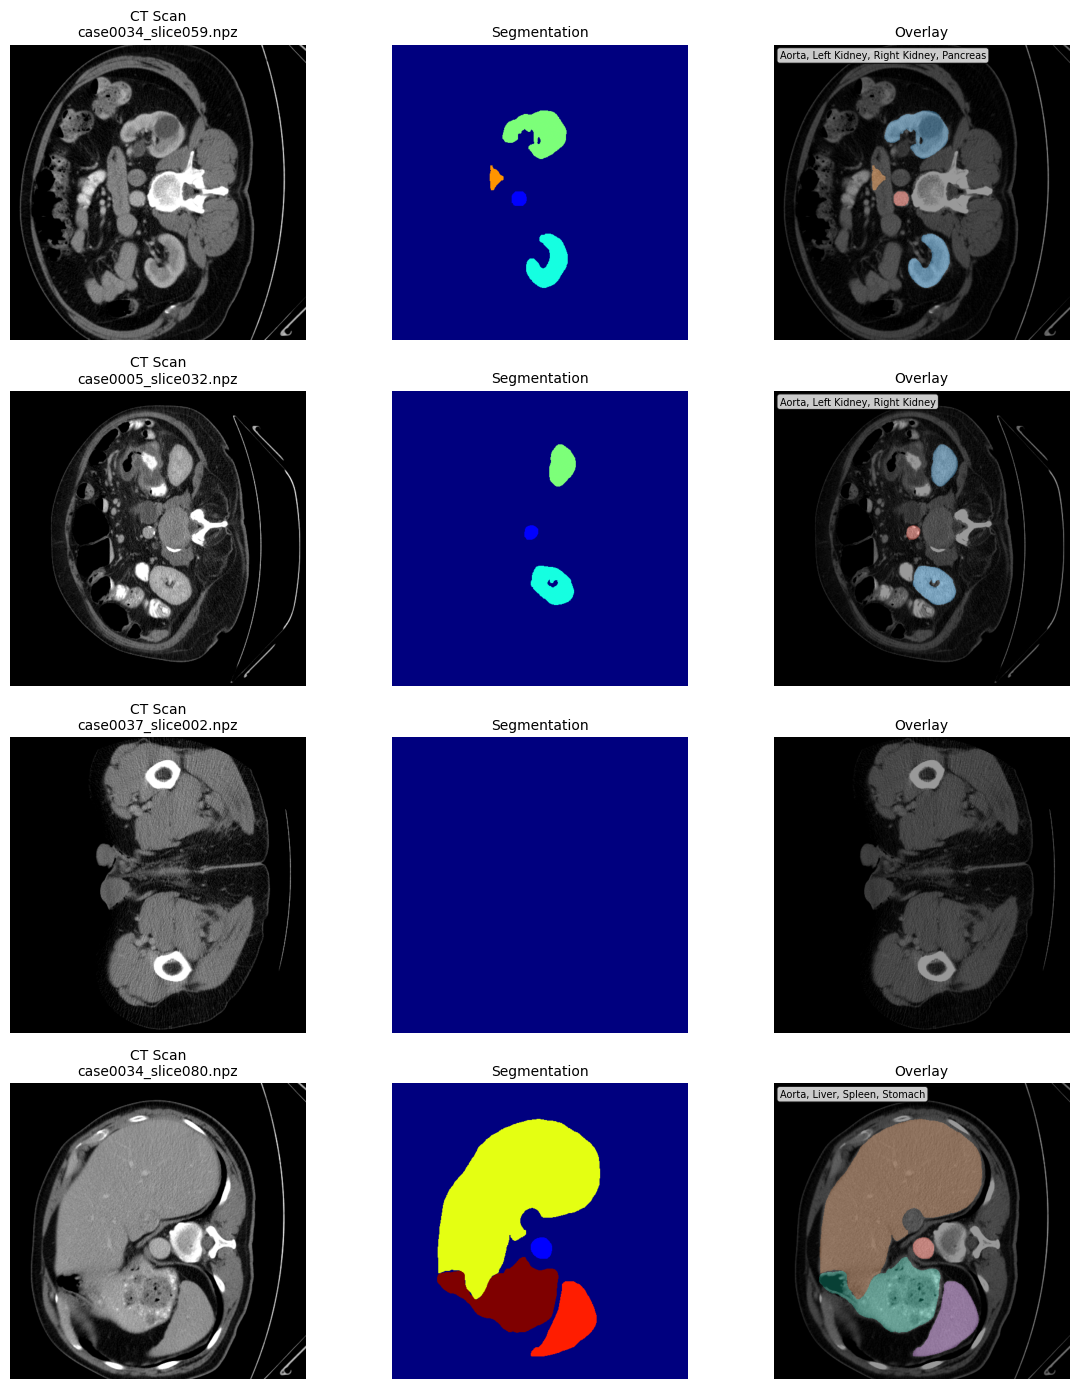

In [11]:
quick_visualize(num_samples=4)

In [8]:
# Class Distribution Analysis
# ----------------------------------------------------------------------------
def analyze_classes(sample_size=300):
    """Analyze class distribution"""
    print("Analyzing class distribution...")

    class_counts = defaultdict(int)
    total = 0

    files = train_files[:sample_size]

    for f in tqdm(files):
        label = np.load(f)['label']
        unique, counts = np.unique(label, return_counts=True)
        for cls, cnt in zip(unique, counts):
            class_counts[int(cls)] += cnt
        total += label.size

    # Results
    print("\n" + "="*60)
    print("CLASS DISTRIBUTION")
    print("="*60)
    print(f"{'ID':<4} {'Organ':<20} {'Pixels':>12} {'Percent':>10}")
    print("-"*60)

    for cls in sorted(class_counts.keys()):
        pct = 100 * class_counts[cls] / total
        print(f"{cls:<4} {ORGAN_NAMES[cls]:<20} {class_counts[cls]:>12,} {pct:>9.2f}%")

    # Visualize
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Bar chart
    classes = sorted(class_counts.keys())
    percentages = [100 * class_counts[c] / total for c in classes]
    colors = [ORGAN_COLORS[c] for c in classes]

    ax1.bar(classes, percentages, color=colors, edgecolor='black', linewidth=1.5)
    ax1.set_xlabel('Class ID', fontweight='bold')
    ax1.set_ylabel('Percentage (%)', fontweight='bold')
    ax1.set_title('Class Distribution', fontweight='bold', fontsize=14)
    ax1.grid(axis='y', alpha=0.3)

    for c, p in zip(classes, percentages):
        ax1.text(c, p, f'{p:.1f}%', ha='center', va='bottom', fontweight='bold')

    # Pie chart (organs only)
    organ_data = [(c, class_counts[c]) for c in classes if c > 0]
    labels = [ORGAN_NAMES[c] for c, _ in organ_data]
    sizes = [cnt for _, cnt in organ_data]
    colors_pie = [ORGAN_COLORS[c] for c, _ in organ_data]

    ax2.pie(sizes, labels=labels, colors=colors_pie, autopct='%1.1f%%',
            startangle=90, textprops={'fontsize': 9, 'fontweight': 'bold'})
    ax2.set_title('Organ Distribution (No BG)', fontweight='bold', fontsize=14)

    plt.tight_layout()
    plt.show()

    return class_counts

Analyzing class distribution...


  0%|          | 0/300 [00:00<?, ?it/s]


CLASS DISTRIBUTION
ID   Organ                      Pixels    Percent
------------------------------------------------------------
0    Background             75,664,653     96.21%
1    Aorta                     108,951      0.14%
2    Gallbladder                45,939      0.06%
3    Left Kidney               199,469      0.25%
4    Right Kidney              197,204      0.25%
5    Liver                   1,794,042      2.28%
6    Pancreas                   89,359      0.11%
7    Spleen                    203,115      0.26%
8    Stomach                   340,468      0.43%


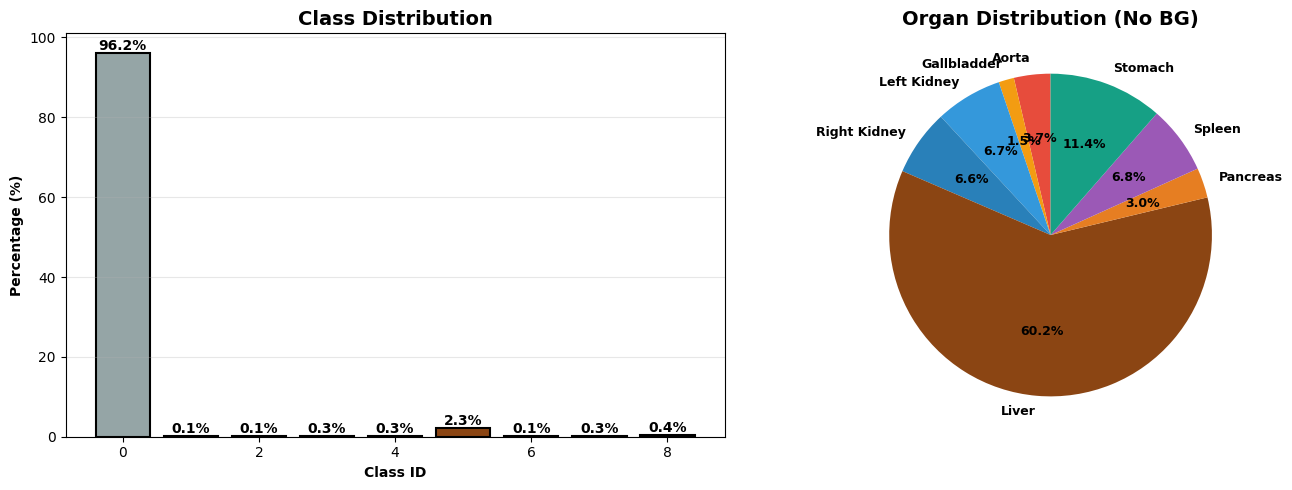

In [13]:
class_counts = analyze_classes(sample_size=300)

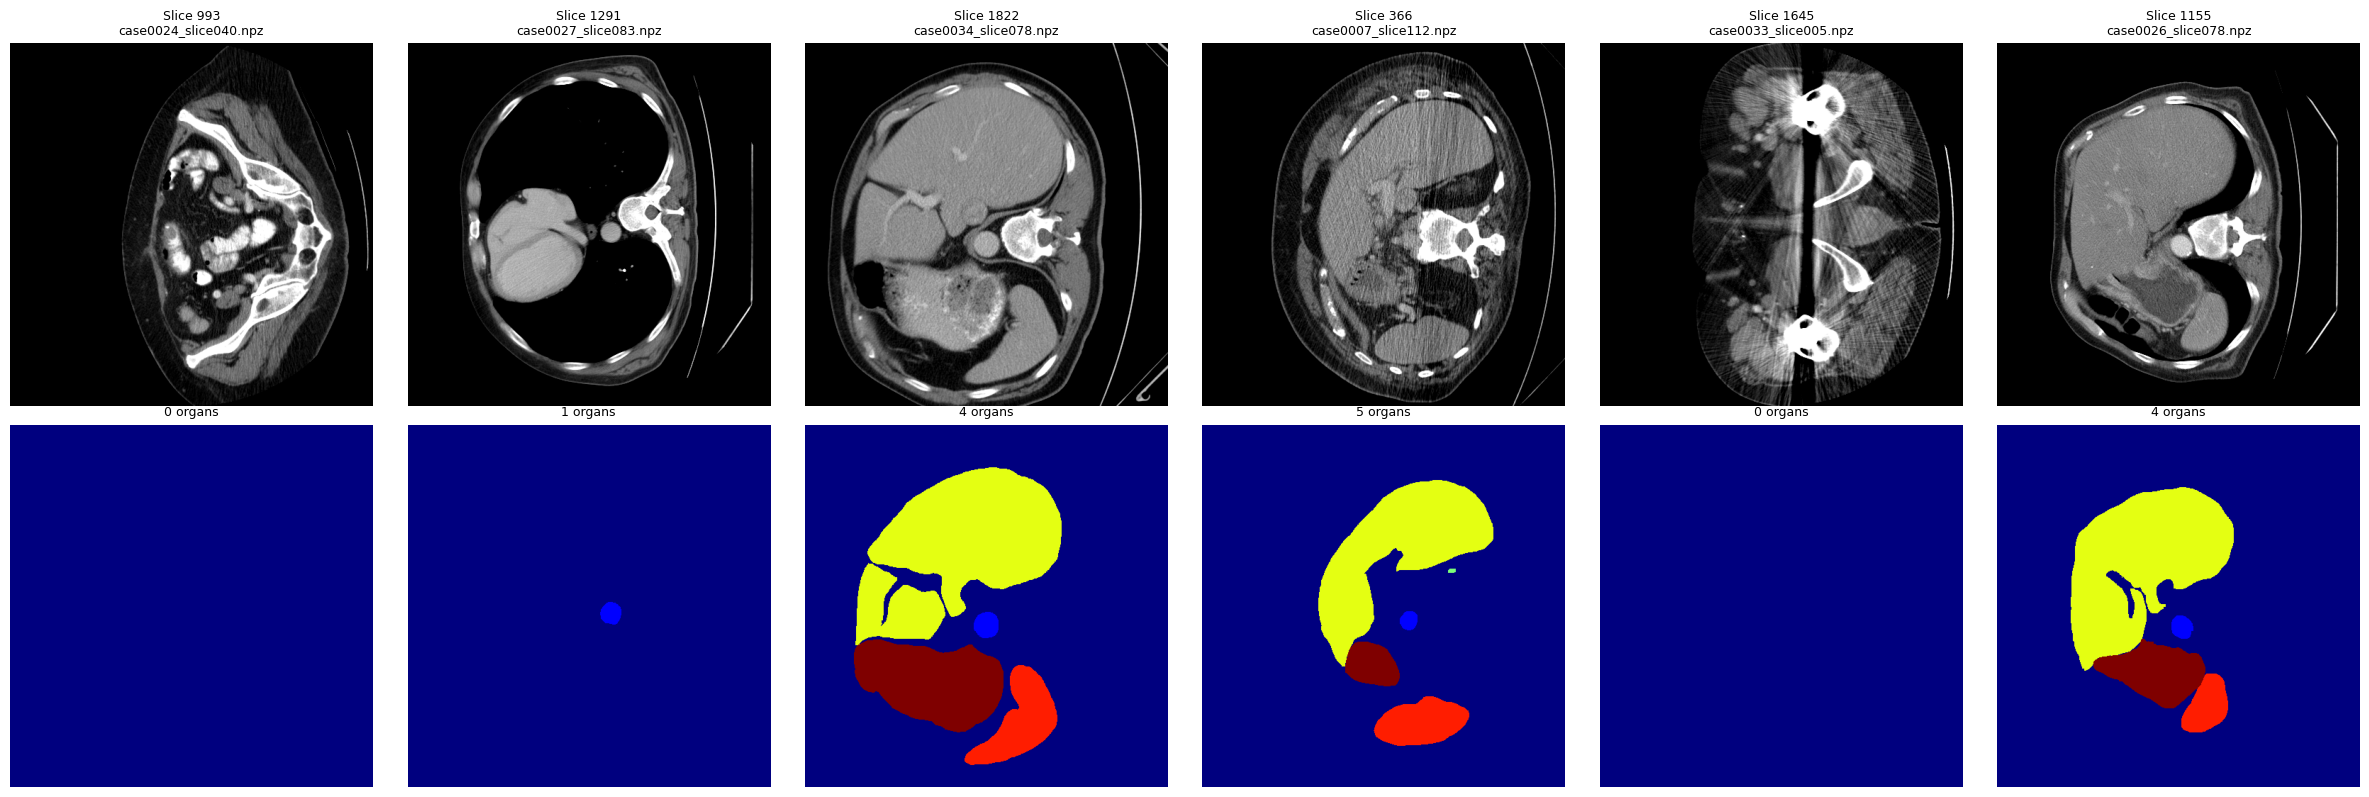

In [9]:
# Compare Multiple Slices
# ----------------------------------------------------------------------------
def compare_slices(indices=None, num_slices=4):
    """Compare multiple slices side by side"""
    if indices is None:
        indices = np.random.choice(len(train_files), num_slices, replace=False)

    fig, axes = plt.subplots(2, num_slices, figsize=(4*num_slices, 8))

    for idx, i in enumerate(indices):
        data = np.load(train_files[i])
        img, label = data['image'], data['label']

        # CT scan
        axes[0, idx].imshow(img, cmap='gray')
        axes[0, idx].set_title(f'Slice {i}\n{Path(train_files[i]).name}', fontsize=9)
        axes[0, idx].axis('off')

        # Segmentation
        axes[1, idx].imshow(label, cmap='jet', vmin=0, vmax=8)
        organs = [ORGAN_NAMES[int(c)] for c in np.unique(label) if c > 0]
        axes[1, idx].set_title(f"{len(organs)} organs", fontsize=9)
        axes[1, idx].axis('off')

    plt.tight_layout()
    plt.show()

# Compare 6 random slices
compare_slices(num_slices=6)

In [10]:
# Check GPU availability
!nvidia-smi

# Install required packages
!pip install torch torchvision torchaudio
!pip install ml-collections
!pip install tensorboardX
!pip install medpy
!pip install SimpleITK
!pip install scipy
!pip install h5py
!pip install opencv-python

/bin/bash: line 1: nvidia-smi: command not found
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.7/76.7 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.3/156.3 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 MB 13.0 MB/s eta 0:00:00
  Created wheel for medpy: filename=MedPy-0.5.2-py3-none-any.whl size=224710 sha256=f19465633199b5ec238d3a38c173e3eebda1a0c0d677a3a46bc7034bf70fbc47
  Stored in directory: /root/.cache/pip/wheels/89/5a/f8/b3def53b9c2133d2f8698ea2173bb5df63bd8e761ce8e9aec9
Successfully built medpy


## Clone the TransUnet paper repository

In [11]:
# Clone the official TransUNet repository
!git clone https://github.com/Beckschen/TransUNet.git
%cd TransUNet

# Alternative: Clone from a fork if needed
# !git clone https://github.com/your-fork/TransUNet.git

Cloning into 'TransUNet'...
remote: Enumerating objects: 119, done.
remote: Counting objects: 100% (79/79), done.
remote: Compressing objects: 100% (31/31), done.
Receiving objects: 100% (119/119), 44.25 KiB | 3.16 MiB/s, done.
remote: Total 119 (delta 65), reused 48 (delta 48), pack-reused 40 (from 1)
Resolving deltas: 100% (65/65), done.
/content/TransUNet


## Download ViT-B/16 pre-trained weights

In [12]:
# Create directory
!mkdir -p ../model/vit_checkpoint/imagenet21k

# Download pretrained weights
!wget https://storage.googleapis.com/vit_models/imagenet21k/R50+ViT-B_16.npz \
    -O ../model/vit_checkpoint/imagenet21k/R50+ViT-B_16.npz

# Verify download
!ls -lh ../model/vit_checkpoint/imagenet21k/

--2026-01-09 10:35:42--  https://storage.googleapis.com/vit_models/imagenet21k/R50+ViT-B_16.npz
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.139.207, 173.194.210.207, 108.177.12.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.139.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 461217452 (440M) [application/octet-stream]
Saving to: ‘../model/vit_checkpoint/imagenet21k/R50+ViT-B_16.npz’

../model/vit_checkp 100%[===================>] 439.85M  41.3MB/s    in 11s     

2026-01-09 10:35:54 (38.3 MB/s) - ‘../model/vit_checkpoint/imagenet21k/R50+ViT-B_16.npz’ saved [461217452/461217452]

total 440M
-rw-r--r-- 1 root root 440M Nov 30  2020 R50+ViT-B_16.npz


In [13]:
import os

TRAIN_DIR = '/content/drive/MyDrive/Dataset/Synapse/train_npz'
TEST_DIR = '/content/drive/MyDrive/Dataset/Synapse/test_vol_h5'
ROOT_DIR = '/content/drive/MyDrive/Dataset/Synapse'

# Create lists directory
!mkdir -p lists/lists_Synapse

# Create train.txt - list all training files (without .npz extension)
train_files = [f.replace('.npz', '') for f in os.listdir(TRAIN_DIR) if f.endswith('.npz')]
with open('lists/lists_Synapse/train.txt', 'w') as f:
    for file in sorted(train_files):
        f.write(file + '\n')

# Create test_vol.txt - list all test files (without .npy.h5 extension)
test_files = [f.replace('.npy.h5', '').replace('.h5', '') for f in os.listdir(TEST_DIR) if f.endswith('.h5')]
with open('lists/lists_Synapse/test_vol.txt', 'w') as f:
    for file in sorted(test_files):
        f.write(file + '\n')

print(f"Created train.txt with {len(train_files)} files")
print(f"Created test_vol.txt with {len(test_files)} files")

Created train.txt with 2226 files
Created test_vol.txt with 12 files


In [16]:
# configs/vit_seg_modeling.py example configuration
"""
Configuration for TransUNet training
"""

import ml_collections

def get_b16_config():
    """Returns the ViT-B/16 configuration."""
    config = ml_collections.ConfigDict()
    config.patches = ml_collections.ConfigDict({'size': (16, 16)})
    config.hidden_size = 768
    config.transformer = ml_collections.ConfigDict()
    config.transformer.mlp_dim = 3072
    config.transformer.num_heads = 12
    config.transformer.num_layers = 12
    config.transformer.attention_dropout_rate = 0.0
    config.transformer.dropout_rate = 0.1

    config.classifier = 'seg'
    config.representation_size = None
    config.resnet_pretrained_path = None
    config.pretrained_path = '../model/vit_checkpoint/imagenet21k/R50+ViT-B_16.npz'
    config.patch_size = 16

    config.decoder_channels = (256, 128, 64, 16)
    config.n_classes = 9  # For Synapse dataset
    config.activation = 'softmax'
    return config

In [17]:
import os

os.makedirs('datasets', exist_ok=True)

with open('datasets/__init__.py', 'w') as f:
    f.write('')

dataset_code = """import os
import random
import h5py
import numpy as np
import torch
from scipy import ndimage
from scipy.ndimage.interpolation import zoom
from torch.utils.data import Dataset


def random_rot_flip(image, label):
    k = np.random.randint(0, 4)
    image = np.rot90(image, k)
    label = np.rot90(label, k)
    axis = np.random.randint(0, 2)
    image = np.flip(image, axis=axis).copy()
    label = np.flip(label, axis=axis).copy()
    return image, label


def random_rotate(image, label):
    angle = np.random.randint(-20, 20)
    image = ndimage.rotate(image, angle, order=0, reshape=False)
    label = ndimage.rotate(label, angle, order=0, reshape=False)
    return image, label


class RandomGenerator(object):
    def __init__(self, output_size):
        self.output_size = output_size

    def __call__(self, sample):
        image, label = sample['image'], sample['label']

        if random.random() > 0.5:
            image, label = random_rot_flip(image, label)
        elif random.random() > 0.5:
            image, label = random_rotate(image, label)
        x, y = image.shape
        if x != self.output_size[0] or y != self.output_size[1]:
            image = zoom(image, (self.output_size[0] / x, self.output_size[1] / y), order=3)
            label = zoom(label, (self.output_size[0] / x, self.output_size[1] / y), order=0)
        image = torch.from_numpy(image.astype(np.float32)).unsqueeze(0)
        label = torch.from_numpy(label.astype(np.float32))
        sample = {'image': image, 'label': label.long()}
        return sample


class Synapse_dataset(Dataset):
    def __init__(self, base_dir, list_dir, split, transform=None):
        self.transform = transform
        self.split = split
        self.sample_list = open(os.path.join(list_dir, self.split+'.txt')).readlines()
        self.data_dir = base_dir

    def __len__(self):
        return len(self.sample_list)

    def __getitem__(self, idx):
        if self.split == "train":
            slice_name = self.sample_list[idx].strip('\\n')
            data_path = os.path.join(self.data_dir, slice_name+'.npz')
            data = np.load(data_path)
            image, label = data['image'], data['label']
        else:
            vol_name = self.sample_list[idx].strip('\\n')
            filepath = self.data_dir + "/{}.npy.h5".format(vol_name)
            data = h5py.File(filepath)
            image, label = data['image'][:], data['label'][:]

        sample = {'image': image, 'label': label}
        if self.transform:
            sample = self.transform(sample)
        sample['case_name'] = self.sample_list[idx].strip('\\n')
        return sample
"""

with open('datasets/dataset_synapse.py', 'w') as f:
    f.write(dataset_code)

print("✓ Created datasets/dataset_synapse.py")

✓ Created datasets/dataset_synapse.py


In [14]:
# Create symbolic link to fix the path
!mkdir -p ../data/Synapse
!ln -s /content/drive/MyDrive/Dataset/Synapse/train_npz ../data/Synapse/train_npz
!ln -s /content/drive/MyDrive/Dataset/Synapse/test_vol_h5 ../data/Synapse/test_vol_h5

# Verify the links
!ls -la ../data/Synapse/

total 8
drwxr-xr-x 2 root root 4096 Jan  9 11:09 .
drwxr-xr-x 3 root root 4096 Jan  9 11:09 ..
lrwxrwxrwx 1 root root   50 Jan  9 11:09 test_vol_h5 -> /content/drive/MyDrive/Dataset/Synapse/test_vol_h5
lrwxrwxrwx 1 root root   48 Jan  9 11:09 train_npz -> /content/drive/MyDrive/Dataset/Synapse/train_npz


In [17]:
!python train.py \
    --dataset Synapse \
    --vit_name R50-ViT-B_16 \
    --max_epochs 50 \
    --batch_size 12 \
    --base_lr 0.01 \
    --img_size 224 \
    --n_gpu 1

Streaming output truncated to the last 5000 lines.
iteration 4304 : loss : 0.075033, loss_ce: 0.016372
iteration 4305 : loss : 0.039212, loss_ce: 0.009167
iteration 4306 : loss : 0.046715, loss_ce: 0.008031
iteration 4307 : loss : 0.056172, loss_ce: 0.021779
iteration 4308 : loss : 0.146628, loss_ce: 0.012562
iteration 4309 : loss : 0.032406, loss_ce: 0.008661
iteration 4310 : loss : 0.246455, loss_ce: 0.004156
iteration 4311 : loss : 0.056135, loss_ce: 0.025231
iteration 4312 : loss : 0.093707, loss_ce: 0.009692
iteration 4313 : loss : 0.065277, loss_ce: 0.014419
iteration 4314 : loss : 0.039631, loss_ce: 0.015801
iteration 4315 : loss : 0.049154, loss_ce: 0.027990
iteration 4316 : loss : 0.038617, loss_ce: 0.010660
iteration 4317 : loss : 0.059516, loss_ce: 0.029665
iteration 4318 : loss : 0.063196, loss_ce: 0.010886
iteration 4319 : loss : 0.099606, loss_ce: 0.011728
iteration 4320 : loss : 0.053582, loss_ce: 0.022569
iteration 4321 : loss : 0.096559, loss_ce: 0.013131
iteration 432

## Testing

Found 12 test cases
Test case: case0001.npy.h5
Image shape: (147, 512, 512)
Label shape: (147, 512, 512)
Predictions shape: (147, 512, 512)


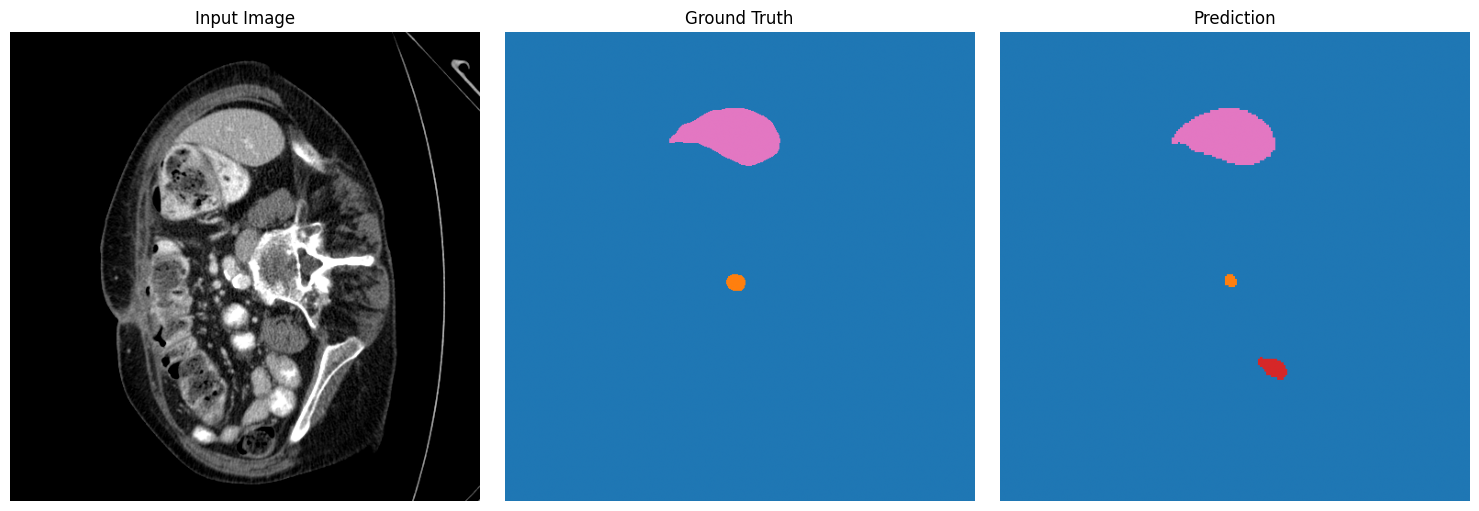

✓ Test complete!


In [23]:
import torch
import numpy as np
import h5py
from networks.vit_seg_modeling import VisionTransformer as ViT_seg
from networks.vit_seg_modeling import CONFIGS as CONFIGS_ViT_seg
from scipy.ndimage import zoom

# Setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
TEST_DIR = '/content/drive/MyDrive/Dataset/Synapse/test_vol_h5'

# Load model
config_vit = CONFIGS_ViT_seg['R50-ViT-B_16']
config_vit.n_classes = 9
config_vit.n_skip = 3
config_vit.patches.grid = (14, 14)

model = ViT_seg(config_vit, img_size=224, num_classes=9)
checkpoint = torch.load('/content/model/TU_Synapse224/TU_pretrain_R50-ViT-B_16_skip3_epo50_bs12_224/epoch_49.pth')
model.load_state_dict(checkpoint)
model = model.to(device)
model.eval()

# Test on one case
import os
test_files = sorted([f for f in os.listdir(TEST_DIR) if f.endswith('.h5')])
print(f"Found {len(test_files)} test cases")

# Load first test case
with h5py.File(os.path.join(TEST_DIR, test_files[0]), 'r') as f:
    image = f['image'][:]
    label = f['label'][:]

print(f"Test case: {test_files[0]}")
print(f"Image shape: {image.shape}")
print(f"Label shape: {label.shape}")

# Run inference on all slices
predictions = []
with torch.no_grad():
    for slice_idx in range(image.shape[0]):
        slice_img = image[slice_idx, :, :]

        # Resize to 224x224
        x, y = slice_img.shape
        slice_img = zoom(slice_img, (224/x, 224/y), order=3)

        # Convert to tensor
        input_tensor = torch.from_numpy(slice_img).unsqueeze(0).unsqueeze(0).float().to(device)

        # Predict
        output = model(input_tensor)
        pred = torch.argmax(torch.softmax(output, dim=1), dim=1).squeeze(0).cpu().numpy()

        # Resize back to original size
        pred = zoom(pred, (x/224, y/224), order=0)
        predictions.append(pred)

predictions = np.array(predictions)
print(f"Predictions shape: {predictions.shape}")

# Visualize results
import matplotlib.pyplot as plt

slice_num = image.shape[0] // 2  # Middle slice

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(image[slice_num], cmap='gray')
axes[0].set_title('Input Image')
axes[0].axis('off')

axes[1].imshow(label[slice_num], cmap='tab10', vmin=0, vmax=8)
axes[1].set_title('Ground Truth')
axes[1].axis('off')

axes[2].imshow(predictions[slice_num], cmap='tab10', vmin=0, vmax=8)
axes[2].set_title('Prediction')
axes[2].axis('off')

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/test_result.png', dpi=150)
plt.show()

print("✓ Test complete!")

## Visualize multiple slices

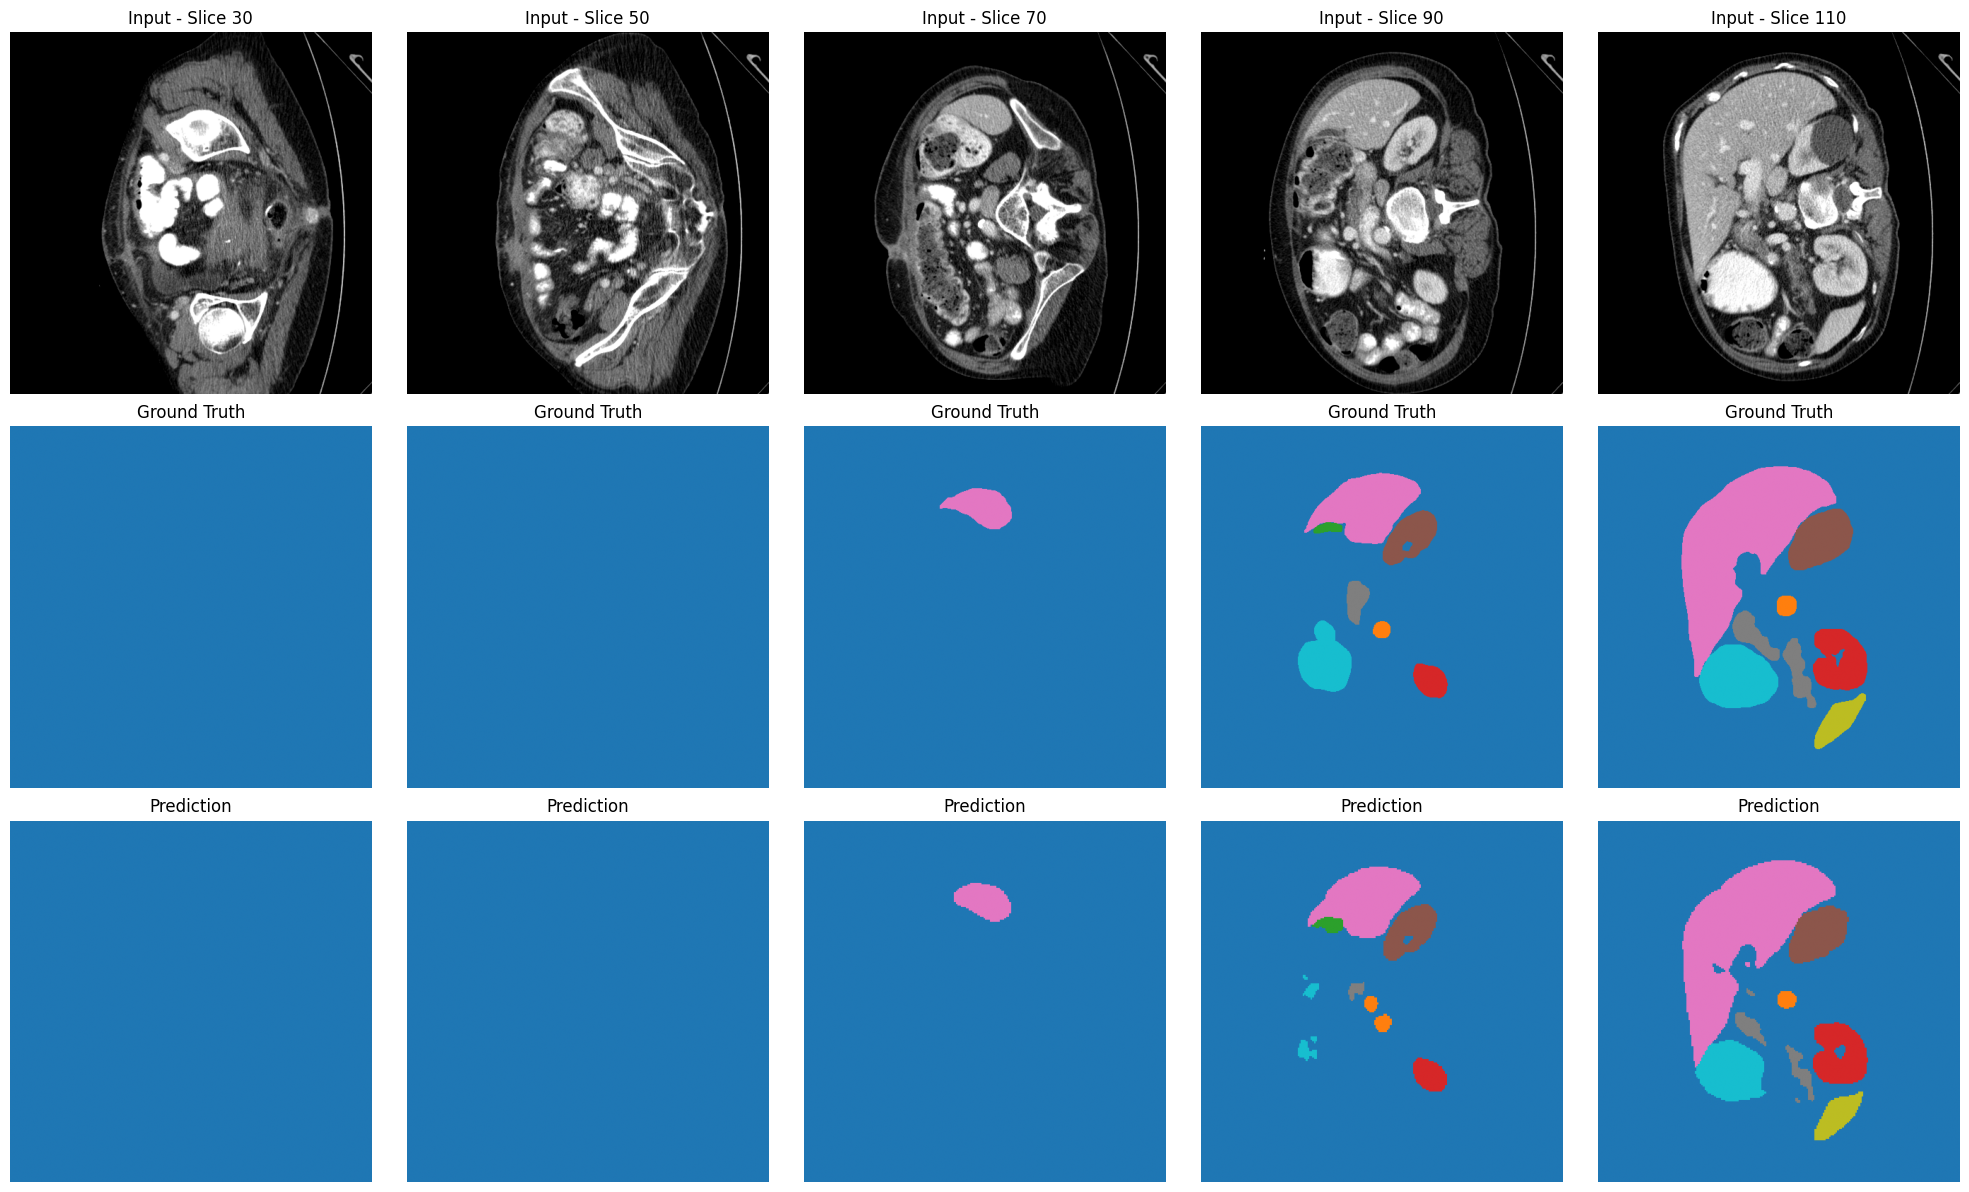

In [25]:
# Visualize multiple slices
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 5, figsize=(20, 12))

# Show 5 different slices
slice_indices = [30, 50, 70, 90, 110]

for idx, slice_num in enumerate(slice_indices):
    # Input image
    axes[0, idx].imshow(image_volume[slice_num], cmap='gray')
    axes[0, idx].set_title(f'Input - Slice {slice_num}')
    axes[0, idx].axis('off')

    # Ground truth
    axes[1, idx].imshow(label_volume[slice_num], cmap='tab10', vmin=0, vmax=8)
    axes[1, idx].set_title('Ground Truth')
    axes[1, idx].axis('off')

    # Prediction
    axes[2, idx].imshow(prediction_volume[slice_num], cmap='tab10', vmin=0, vmax=8)
    axes[2, idx].set_title('Prediction')
    axes[2, idx].axis('off')

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/test_results_multiple_slices.png', dpi=150)
plt.show()

## Evaluation


Testing case0001.npy.h5...
Mean Dice: 0.7785

Testing case0002.npy.h5...
Mean Dice: 0.8642

Testing case0003.npy.h5...
Mean Dice: 0.6347

Testing case0004.npy.h5...
Mean Dice: 0.7746

Testing case0008.npy.h5...
Mean Dice: 0.6589

Testing case0022.npy.h5...
Mean Dice: 0.8993

Testing case0025.npy.h5...
Mean Dice: 0.7857

Testing case0029.npy.h5...
Mean Dice: 0.6907

Testing case0032.npy.h5...
Mean Dice: 0.8071

Testing case0035.npy.h5...
Mean Dice: 0.7452

Testing case0036.npy.h5...
Mean Dice: 0.8372

Testing case0038.npy.h5...
Mean Dice: 0.7340

EVALUATION RESULTS - ALL TEST CASES
    case  mean_dice  mean_iou  mean_precision  mean_recall
case0001   0.778485  0.670452        0.810921     0.775395
case0002   0.864179  0.772277        0.844235     0.886048
case0003   0.634727  0.477669        0.661517     0.659566
case0004   0.774589  0.672831        0.837927     0.735446
case0008   0.658920  0.555631        0.656929     0.678462
case0022   0.899256  0.820225        0.889468     0.91147

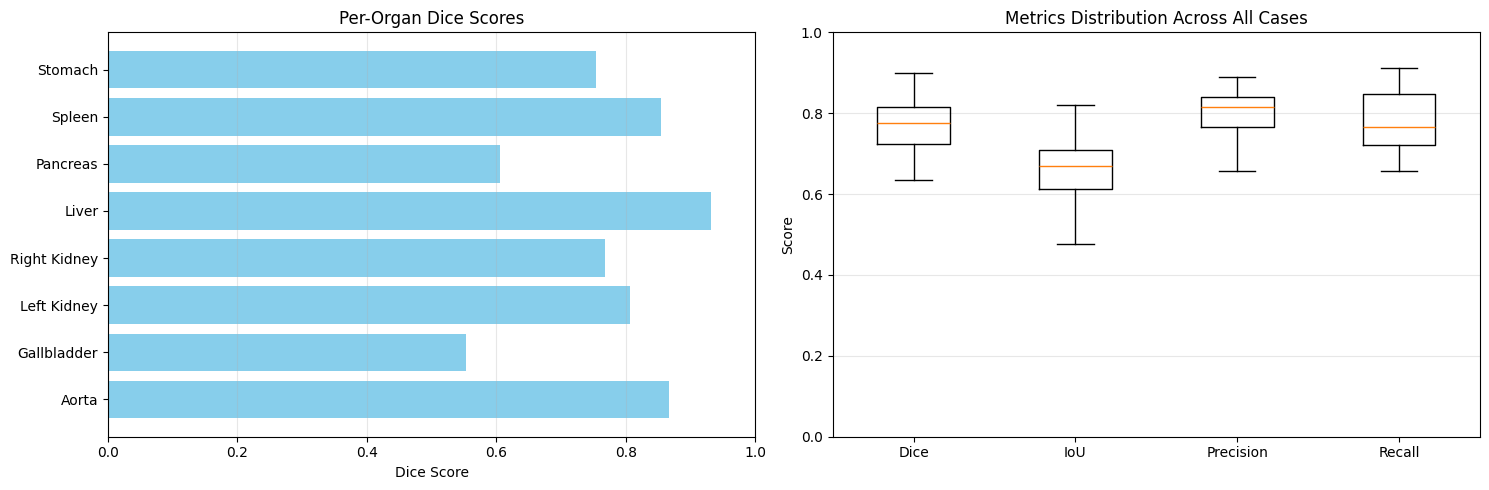


✓ Evaluation complete!


In [26]:
import numpy as np
import pandas as pd

def calculate_metrics(pred, target, num_classes=9):
    """Calculate Dice, IoU, Precision, Recall for each class"""
    metrics = {
        'dice': [],
        'iou': [],
        'precision': [],
        'recall': []
    }

    for i in range(1, num_classes):  # Skip background (class 0)
        pred_i = (pred == i)
        target_i = (target == i)

        intersection = np.sum(pred_i & target_i)
        pred_sum = np.sum(pred_i)
        target_sum = np.sum(target_i)
        union = pred_sum + target_sum - intersection

        # Dice Score
        if pred_sum + target_sum == 0:
            dice = np.nan
        else:
            dice = 2 * intersection / (pred_sum + target_sum)

        # IoU
        if union == 0:
            iou = np.nan
        else:
            iou = intersection / union

        # Precision
        if pred_sum == 0:
            precision = np.nan
        else:
            precision = intersection / pred_sum

        # Recall
        if target_sum == 0:
            recall = np.nan
        else:
            recall = intersection / target_sum

        metrics['dice'].append(dice)
        metrics['iou'].append(iou)
        metrics['precision'].append(precision)
        metrics['recall'].append(recall)

    return metrics


# Organ names for Synapse dataset
organ_names = ['Aorta', 'Gallbladder', 'Left Kidney', 'Right Kidney',
               'Liver', 'Pancreas', 'Spleen', 'Stomach']

# Test all cases and collect metrics
all_results = []

for test_file in test_files:
    print(f"\nTesting {test_file}...")

    # Load volume
    with h5py.File(os.path.join(TEST_DIR, test_file), 'r') as f:
        image_vol = f['image'][:]
        label_vol = f['label'][:]

    # Predict all slices
    pred_vol = []
    with torch.no_grad():
        for i in range(image_vol.shape[0]):
            slice_2d = image_vol[i]
            h, w = slice_2d.shape
            slice_resized = zoom(slice_2d, (224/h, 224/w), order=3)
            input_tensor = torch.from_numpy(slice_resized).unsqueeze(0).unsqueeze(0).float().to(device)
            output = model(input_tensor)
            pred = torch.argmax(torch.softmax(output, dim=1), dim=1).squeeze(0).cpu().numpy()
            pred = zoom(pred, (h/224, w/224), order=0)
            pred_vol.append(pred)

    pred_vol = np.stack(pred_vol)

    # Calculate metrics
    metrics = calculate_metrics(pred_vol, label_vol)

    # Store results
    result = {
        'case': test_file.replace('.npy.h5', ''),
        'mean_dice': np.nanmean(metrics['dice']),
        'mean_iou': np.nanmean(metrics['iou']),
        'mean_precision': np.nanmean(metrics['precision']),
        'mean_recall': np.nanmean(metrics['recall'])
    }

    # Add per-organ Dice scores
    for i, organ in enumerate(organ_names):
        result[f'dice_{organ}'] = metrics['dice'][i]

    all_results.append(result)

    print(f"Mean Dice: {result['mean_dice']:.4f}")

# Create DataFrame
df_results = pd.DataFrame(all_results)

# Display results
print("\n" + "="*80)
print("EVALUATION RESULTS - ALL TEST CASES")
print("="*80)
print(df_results[['case', 'mean_dice', 'mean_iou', 'mean_precision', 'mean_recall']].to_string(index=False))

# Overall statistics
print("\n" + "="*80)
print("OVERALL STATISTICS")
print("="*80)
print(f"Mean Dice Score: {df_results['mean_dice'].mean():.4f} ± {df_results['mean_dice'].std():.4f}")
print(f"Mean IoU: {df_results['mean_iou'].mean():.4f} ± {df_results['mean_iou'].std():.4f}")
print(f"Mean Precision: {df_results['mean_precision'].mean():.4f} ± {df_results['mean_precision'].std():.4f}")
print(f"Mean Recall: {df_results['mean_recall'].mean():.4f} ± {df_results['mean_recall'].std():.4f}")

# Per-organ Dice scores
print("\n" + "="*80)
print("PER-ORGAN DICE SCORES")
print("="*80)
for organ in organ_names:
    organ_dice = df_results[f'dice_{organ}'].mean()
    print(f"{organ:20s}: {organ_dice:.4f}")

# Save results to CSV
df_results.to_csv('/content/drive/MyDrive/evaluation_results.csv', index=False)
print(f"\n✓ Results saved to /content/drive/MyDrive/evaluation_results.csv")

# Visualize results
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Bar plot of per-organ Dice scores
organ_dice_scores = [df_results[f'dice_{organ}'].mean() for organ in organ_names]
axes[0].barh(organ_names, organ_dice_scores, color='skyblue')
axes[0].set_xlabel('Dice Score')
axes[0].set_title('Per-Organ Dice Scores')
axes[0].set_xlim(0, 1)
axes[0].grid(axis='x', alpha=0.3)

# Box plot of Dice scores across all cases
axes[1].boxplot([df_results['mean_dice'], df_results['mean_iou'],
                  df_results['mean_precision'], df_results['mean_recall']])
axes[1].set_xticklabels(['Dice', 'IoU', 'Precision', 'Recall'])
axes[1].set_ylabel('Score')
axes[1].set_title('Metrics Distribution Across All Cases')
axes[1].set_ylim(0, 1)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/evaluation_metrics.png', dpi=150)
plt.show()

print("\n✓ Evaluation complete!")